In [14]:
import numpy as np
import tensorflow as tf
import gym
import random
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline



def stats(rewards):
    print("Mean reward: ", np.mean(rewards))
    rewards_100 = []
    for i in range(100, len(rewards) + 1):
        rewards_100.append(np.mean(rewards[i-100:i]))
    #print("Max 100 rewards mean: ", np.max(rewards_100))
    #re = np.argmax(rewards_100)
    #print("Max 100 rewards from episode: %d, to episode: %d" % (re, re + 99))
    plt.plot(rewards_100)
    plt.xlabel('episodes')
    plt.ylabel('rewards')
    plt.show()
    
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)
    
def train(num_iterations=10):
    env = gym.make('CartPole-v0')
    env._max_episode_steps = 1000
    max_num_episodes = 5000
    checkpoint = 400
    replay_experience_maxlen = 50000
    batch_size = 64
    #num_iterations = 10
    #final_episodes = []

    learning_rate = 0.001
    decay = 0.99
    training_rewards = []
        

    augs = ['ras', None, 'gn']
        
    for aug in augs:
        curr_rewards = []
        final_episodes = []
        for i in range(num_iterations):
            print("----------------ITERATION: ", i, aug)
            tf.compat.v1.reset_default_graph()
            X = tf.placeholder(dtype=tf.float32, shape=(None, 4))
            y = tf.placeholder(dtype=tf.float32, shape=(None, 2))
            net = tf.contrib.layers.fully_connected(X, 15)
            Q = tf.contrib.layers.fully_connected(net, 2, activation_fn=None)
            mse = tf.contrib.losses.mean_squared_error(y, Q)
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

            all_rewards = []



            sess = tf.InteractiveSession()
            tf.global_variables_initializer().run()

            # Initialize empty experiences
            replay_experience = deque(maxlen=replay_experience_maxlen)
            for episode in range(max_num_episodes):
                state = env.reset()
                epsilon = 1./((episode/50) + 10)
                done = False
                episode_reward = 0
                while not done:
                    # Calculate Q(s, a) for all a
                    Q_s_A = Q.eval(feed_dict={X: state.reshape((1, 4))})

                    # Choose action based on epsilon-greedy policy
                    if np.random.random_sample() < epsilon:
                        action = env.action_space.sample()
                    else:
                        action = np.argmax(Q_s_A[0])

                    # Perform action
                    next_state, reward, done, _ = env.step(action)

                    # Append final reward for each episode
                    episode_reward += reward

                    # Change 0 reward to -1 to learn more from punishment
                    if done:
                        reward = -1.0

                    # Save experience
                    replay_experience.append([state, action, reward, next_state, done])

                    # Switch to next state
                    state = next_state

                    # Do training if replay_experience contains enough sample > batch_size
                    if len(replay_experience) > batch_size:
                        

                        ## 1- Sample from replay experience
                        batch = random.sample(replay_experience, batch_size)
                        states = np.vstack([x[0] for x in batch])

                        actions = np.array([x[1] for x in batch])
                        rewards = np.array([x[2] for x in batch])
                        next_states = np.vstack([x[3] for x in batch])
                        if aug == 'ras':
                            low = np.random.uniform(0.6, 0.8)
                            high = np.random.uniform(1.2, 1.4)
                            scaling = np.random.uniform(low, high)
                            next_states *= scaling
                            states *= scaling
                        elif aug == 'gn':
                            mean = np.mean(states)
                            std = np.std(states)
                            noise = np.random.normal(mean, std)
                            states += noise
                            next_states += noise

                        episodes_done = np.array([x[4] for x in batch])
                        target_Q = Q.eval(feed_dict={X: states})
                        target_Q[range(batch_size), actions] = rewards + decay * np.max(Q.eval(feed_dict={X: next_states}), axis=1) * ~episodes_done
                        train_step.run(feed_dict={X: states, y: target_Q})

                if (episode + 1) % checkpoint == 0:
                    print("Episode: %d, Mean reward: %d" % (episode, np.mean(all_rewards[-100:])))

                all_rewards.append(episode_reward)
                #print('np.mean is: ', np.mean(all_rewards[-100:]))
                if np.mean(all_rewards[-100:]) > 300 or episode == max_num_episodes - 1:
                    print('Done with episode #', episode + 1)
                    final_episodes.append(episode + 1)
                    curr_rewards.append(all_rewards)
                    break

            #stats(all_rewards)
        print('final_episodes: ', len(final_episodes))
        print('final_episodes stats: ', np.mean(final_episodes), np.std(final_episodes))
        training_rewards.append(curr_rewards)
    return training_rewards




In [15]:
rewards = train(5)

----------------ITERATION:  0 ras
Episode: 399, Mean reward: 225
Done with episode # 579
----------------ITERATION:  1 ras
Done with episode # 222
----------------ITERATION:  2 ras
Done with episode # 215
----------------ITERATION:  3 ras
Done with episode # 345
----------------ITERATION:  4 ras
Episode: 399, Mean reward: 192
Episode: 799, Mean reward: 139
Done with episode # 822
final_episodes:  5
final_episodes stats:  436.6 233.39288763799124
----------------ITERATION:  0 None
Done with episode # 308
----------------ITERATION:  1 None
Episode: 399, Mean reward: 251
Done with episode # 462
----------------ITERATION:  2 None
Episode: 399, Mean reward: 134
Episode: 799, Mean reward: 40
Done with episode # 1032
----------------ITERATION:  3 None
Episode: 399, Mean reward: 256
Done with episode # 513
----------------ITERATION:  4 None
Done with episode # 356
final_episodes:  5
final_episodes stats:  534.2 259.37956742966475
----------------ITERATION:  0 gn
Episode: 399, Mean reward: 29
E

Mean reward:  164.11354420113543


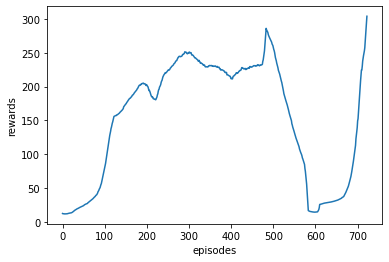

Mean reward:  132.61810400516796


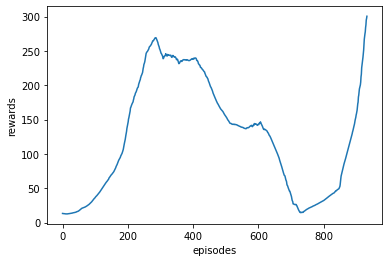

Mean reward:  104.26744000000001


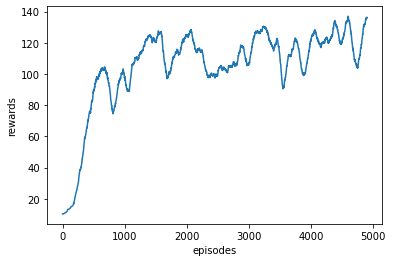

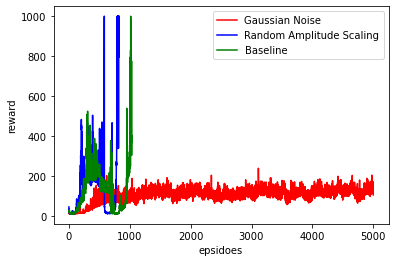

In [16]:
#print(rewards)

y_ras, _ = tolerant_mean(rewards[0])
stats(y_ras)
y_base, _ = tolerant_mean(rewards[1])
stats(y_base)
y_gn, _ = tolerant_mean(rewards[2])
stats(y_gn)
plt.plot(np.arange(len(y_gn))+1, y_gn, color='red', label='Gaussian Noise')
plt.plot(np.arange(len(y_ras))+1, y_ras, color='blue', label='Random Amplitude Scaling')
plt.plot(np.arange(len(y_base))+1, y_base, color='green', label='Baseline')
plt.xlabel('epsidoes')
plt.ylabel('reward')
plt.legend()
plt.show()

In [ ]:
 print("Play 10 times with optimal policy")
    avg_rewards = []
    for i in range(10):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state, reward, done, _ = env.step(np.argmax(Q.eval(feed_dict={X: state.reshape((1, 4))})))
            #print(state, reward, done)
            total_reward += reward
            #env.render()
        avg_rewards.append(total_reward)
        print("Iteration: %d, Total Reward: %d" % (i, total_reward))
    final_rewards.append(np.mean(avg_rewards))